## Preparation

Text(0.5,1,'S&P500 Weekly Closing Index')

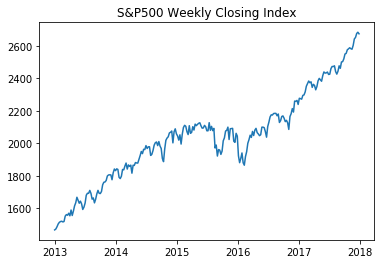

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn
import warnings
warnings.filterwarnings('ignore')
%load_ext rpy2.ipython
%matplotlib inline

df = pd.read_csv('D:/data/sp500-weekly.csv', index_col = 'Date')
df.index = pd.to_datetime(df.index)
df = df.drop('Adj Close', 1)
ts = df['Close']
plt.plot(ts)
plt.title('S&P500 Weekly Closing Index')

Text(0.5,1,'Log Transformation')

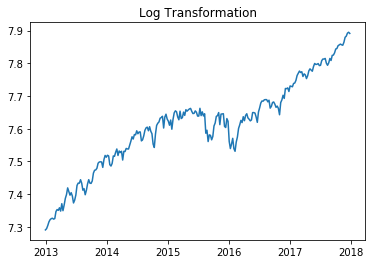

In [2]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.title("Log Transformation")

Text(0.5,1,'Log Differencing')

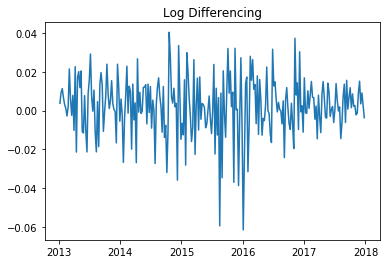

In [3]:
ts_log_diff = ts_log.diff(1)
ts_log_diff.dropna(inplace = True)
plt.plot(ts_log_diff)
plt.title("Log Differencing")

In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import statsmodels


def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    rol_mean = timeSeries.rolling(window=size).mean()
    rol_weighted_mean = timeSeries.ewm(span=12,min_periods=0,
                                   adjust=True,ignore_na=False).mean()
    rol_std = timeSeries.rolling(window = size).std()


    timeSeries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    rol_std.plot(color = 'green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()

'''
　　Unit Root Test
   The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
   root, with the alternative that there is no unit root. That is to say the
   bigger the p-value the more reason we assert that there is a unit root
'''
def testStationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value','#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

def draw_acf_pacf(ts, lags=31):
    plot_acf(ts, lags=lags)
    plot_pacf(ts, lags=lags)
    plt.show()

## ADF Test

In [5]:
testStationarity(ts_log_diff)

Test Statistic                -7.856133e+00
p-value                        5.436661e-12
#Lags Used                     6.000000e+00
Number of Observations Used    2.530000e+02
Critical Value (1%)           -3.456464e+00
Critical Value (5%)           -2.873033e+00
Critical Value (10%)          -2.572895e+00
dtype: float64

## ACF&PACF Plot

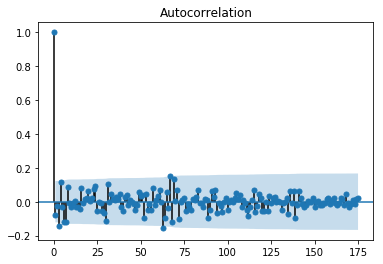

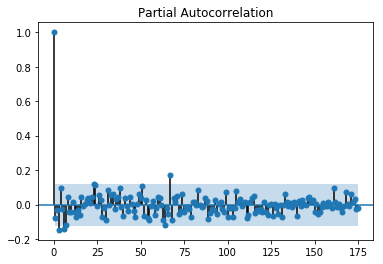

In [6]:
draw_acf_pacf(ts_log_diff, lags = 175)

## ARMA Modeling

Text(0.5,1,'RSS: 0.0569')

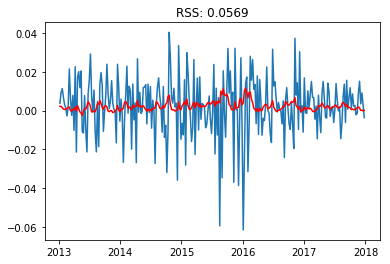

In [23]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_log_diff, order = (1, 1))
result_arma = model.fit(disp = -1)
plt.plot(ts_log_diff)
plt.plot(result_arma.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((result_arma.fittedvalues-ts_log_diff)**2))

## Residuals Examination

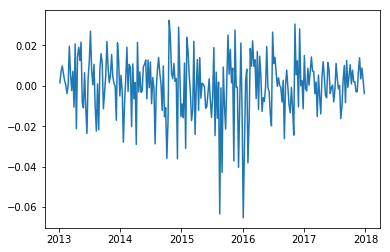

In [24]:
plt.plot(result_arma.resid)

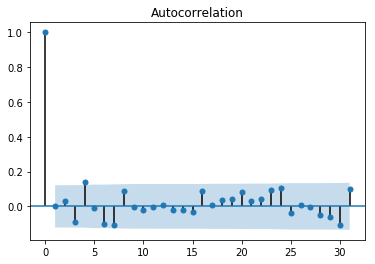

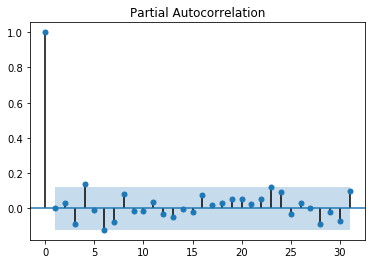

In [25]:
test = np.array(result_arma.resid)
draw_acf_pacf(result_arma.resid)

In [31]:
%%R -i test -o out
library(tseries)
out = Box.test(test, lag = 5, type = "Ljung-Box")

In [32]:
print(out)



	Box-Ljung test



data:  test

X-squared = 7.5469, df = 5, p-value = 0.183





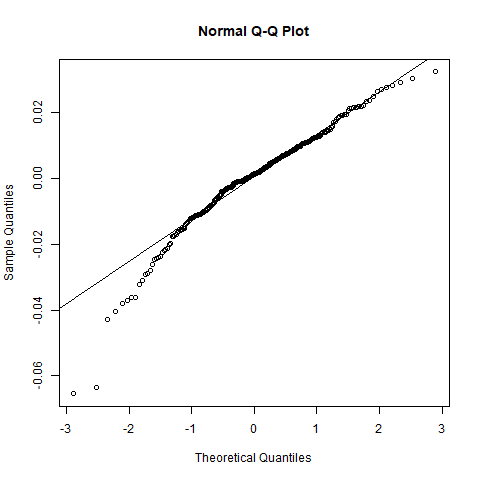

In [112]:
%%R -i test
qqnorm(test)
qqline(test)

## FARIMA Modeling

In [78]:
import math
def factorial_frac(d, t):
    if t <= 0 :
        return 1
    else:
        return d*factorial_frac(d-1, t-1)
    
    
def diff_frac(timeSeries, d, cut = 10):
    result = timeSeries
    for i in range(0, cut):
        result = result + (factorial_frac(d, i+1)/math.factorial(i+1)
                           *((-1)**(i+1))*result.shift(i+1))
    result.dropna(inplace = True)
    return result

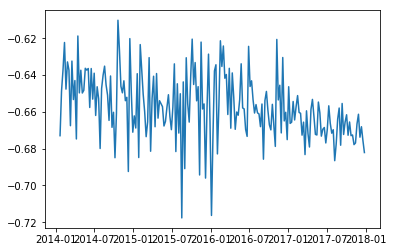

In [90]:
ts_log_diff_108 = diff_frac(ts_log, 1.08)
plt.plot(ts_log_diff_108)

In [91]:
testStationarity(ts_log_diff_108)

Test Statistic                  -4.571947
p-value                          0.000145
#Lags Used                       3.000000
Number of Observations Used    202.000000
Critical Value (1%)             -3.463144
Critical Value (5%)             -2.875957
Critical Value (10%)            -2.574455
dtype: float64

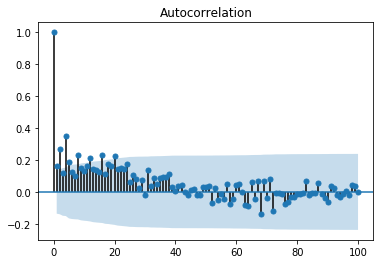

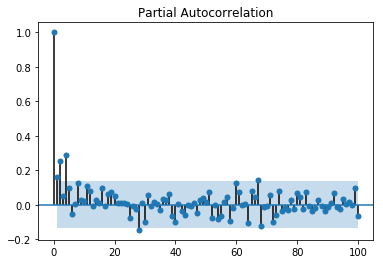

In [92]:
draw_acf_pacf(ts_log_diff_11, lags = 100)

Text(0.5,1,'RSS: 0.0602')

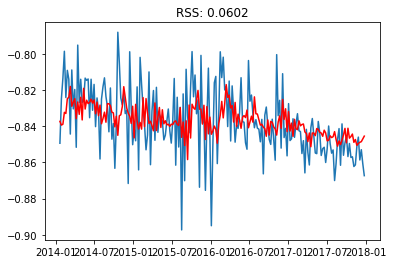

In [98]:
from statsmodels.tsa.arima_model import ARMA
model2 = ARMA(ts_log_diff_11, order = (4, 0))
result2_arma = model2.fit(disp = -1)
plt.plot(ts_log_diff_11)
plt.plot(result2_arma.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((result2_arma.fittedvalues-ts_log_diff_11)**2))

## Residuals Examination

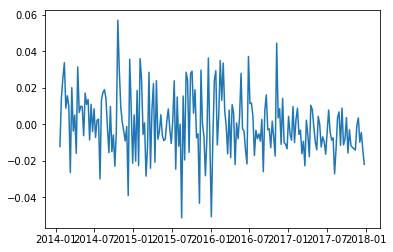

In [100]:
test2 = np.array(result2_arma.resid)
plt.plot(result2_arma.resid)

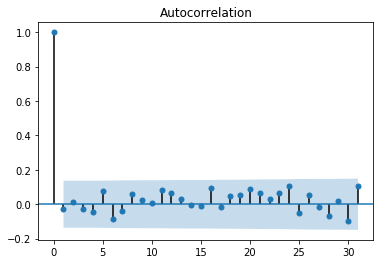

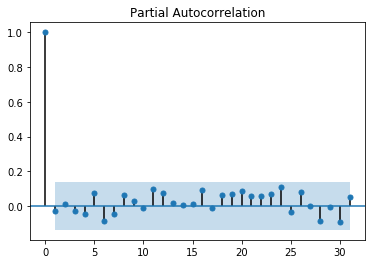

In [110]:
draw_acf_pacf(result2_arma.resid)

In [107]:
%%R -i test2 -o out
library(tseries)
out = Box.test(test2, lag = 5, type = "Ljung-Box")

In [108]:
print(out)



	Box-Ljung test



data:  test2

X-squared = 2.0081, df = 5, p-value = 0.848





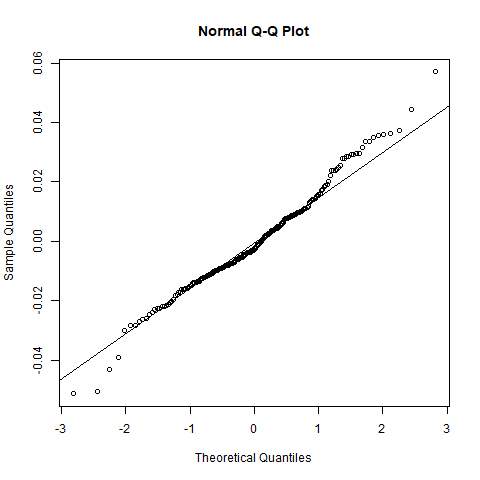

In [111]:
%%R -i test2
qqnorm(test2)
qqline(test2)